##Problem 1 - CIFAR-100 Classification
Please change the Edit>Notebook>Hardware Accelerator settings in Colab from None to GPU.

In [2]:
# Check the GPU information
!nvidia-smi

Wed Apr 19 14:20:44 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# CIFAR-100 classification
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader

# Define the batch size
batch_size = 256

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the transform to normalize the data
transform = torchvision.transforms.Compose([
    transforms.Resize((224, 224)), # Resize to 224x224 (height x width)
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])
])

# Load the training set
train_set = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)

# Load the test set
test_set = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)

# Create data loaders to load the data in batches
train_loader = DataLoader(
    train_set, 
    batch_size=batch_size, 
    shuffle=True
)

test_loader = DataLoader(
    test_set, 
    batch_size=batch_size, 
    shuffle=False
)

100%|██████████| 169001437/169001437 [00:04<00:00, 40340974.37it/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
# Define the model
from torchvision.models import resnet18, ResNet18_Weights

# Use pretrained weights
net = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1).cuda()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 134MB/s]


In [5]:
# Define the loss and the optimizer
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.nn as nn

epochs = 5
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
scheduler = CosineAnnealingLR(optimizer, epochs, eta_min=0, last_epoch=- 1, verbose=False)

In [6]:
# Train the network
acc_list = []
for epoch in range(epochs):  # Loop over the dataset multiple times
    net.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # Get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.cuda()
        labels = labels.cuda()

        # Zero the parameter gradients
        optimizer.zero_grad()
        # Forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        if i % 10 == 0:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

    scheduler.step()
            
    # Test the network
    net.eval()
    correct = 0
    total = 0
    # Since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in test_loader:
            # Calculate outputs by running images through the network
            images, labels = data
            images = images.cuda()
            labels = labels.cuda()
            outputs = net(images)
            # The class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
        acc_list.append(100 * correct // total)

    print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')
print('Finished Training')

[1,     1] loss: 0.005
[1,    11] loss: 0.041
[1,    21] loss: 0.026
[1,    31] loss: 0.020
[1,    41] loss: 0.017
[1,    51] loss: 0.015
[1,    61] loss: 0.014
[1,    71] loss: 0.012
[1,    81] loss: 0.011
[1,    91] loss: 0.010
[1,   101] loss: 0.009
[1,   111] loss: 0.009
[1,   121] loss: 0.008
[1,   131] loss: 0.008
[1,   141] loss: 0.008
[1,   151] loss: 0.008
[1,   161] loss: 0.007
[1,   171] loss: 0.007
[1,   181] loss: 0.007
[1,   191] loss: 0.006
Accuracy of the network on the 10000 test images: 62 %
[2,     1] loss: 0.001
[2,    11] loss: 0.005
[2,    21] loss: 0.005
[2,    31] loss: 0.005
[2,    41] loss: 0.005
[2,    51] loss: 0.005
[2,    61] loss: 0.005
[2,    71] loss: 0.005
[2,    81] loss: 0.005
[2,    91] loss: 0.004
[2,   101] loss: 0.005
[2,   111] loss: 0.004
[2,   121] loss: 0.005
[2,   131] loss: 0.004
[2,   141] loss: 0.005
[2,   151] loss: 0.004
[2,   161] loss: 0.004
[2,   171] loss: 0.004
[2,   181] loss: 0.004
[2,   191] loss: 0.004
Accuracy of the network o

##Problem 2 - Flowers102 Classification
Note: for the last step, plot the testing accuracy curve across the epochs. To do this, remember to store all the accuracy numbers in a Python list during the training.

In [7]:
# Flowers102 classification
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader

# Define the batch size
batch_size = 256

# Define the transform to normalize the data
# Resize to 224x224 (height x width)
transform = torchvision.transforms.Compose([
    transforms.Resize((224, 224)), # Resize to 224x224 (height x width)
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])
])

# Load the training set
train_set = torchvision.datasets.Flowers102(root='./data', split = 'train', download=True, transform=transform)

# Load the test set
test_set = torchvision.datasets.Flowers102(root='./data', split = 'test', download=True, transform=transform)

# Create data loaders to load the data in batches
train_loader = DataLoader(
    train_set, 
    batch_size=batch_size, 
    shuffle=True
)

test_loader = DataLoader(
    test_set, 
    batch_size=batch_size, 
    shuffle=False
)

100%|██████████| 344862509/344862509 [00:12<00:00, 28492539.78it/s]


Extracting data/flowers-102/102flowers.tgz to data/flowers-102


100%|██████████| 502/502 [00:00<00:00, 710611.07it/s]


100%|██████████| 14989/14989 [00:00<00:00, 14327352.47it/s]


In [8]:
# Define the model
from torchvision.models import resnet18, ResNet18_Weights

# Using pretrained weights:
net = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1).cuda()

In [9]:
# Define the loss and the optimizer
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.nn as nn

epochs = 20
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
scheduler = CosineAnnealingLR(optimizer, epochs, eta_min=0, last_epoch=- 1, verbose=False)

In [10]:
# Train the network
acc_list = []

for epoch in range(epochs):  # Loop over the dataset multiple times
    net.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs = inputs.cuda()
        labels = labels.cuda()

        # Zero the parameter gradients
        optimizer.zero_grad()
        # Forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        if i % 10 == 0:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

    scheduler.step()
            
    # Test the network
    net.eval()
    correct = 0
    total = 0
    # Since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in test_loader:
             # Calculate outputs by running images through the network
            images, labels = data
            images = images.cuda()
            labels = labels.cuda()
            outputs = net(images)
            # The class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        acc_list.append(100 * correct // total)

    print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')
print('Finished Training')

[1,     1] loss: 0.005
Accuracy of the network on the 10000 test images: 1 %
[2,     1] loss: 0.004
Accuracy of the network on the 10000 test images: 12 %
[3,     1] loss: 0.002
Accuracy of the network on the 10000 test images: 25 %
[4,     1] loss: 0.001
Accuracy of the network on the 10000 test images: 36 %
[5,     1] loss: 0.000
Accuracy of the network on the 10000 test images: 46 %
[6,     1] loss: 0.000
Accuracy of the network on the 10000 test images: 52 %
[7,     1] loss: 0.000
Accuracy of the network on the 10000 test images: 57 %
[8,     1] loss: 0.000
Accuracy of the network on the 10000 test images: 60 %
[9,     1] loss: 0.000
Accuracy of the network on the 10000 test images: 61 %
[10,     1] loss: 0.000
Accuracy of the network on the 10000 test images: 63 %
[11,     1] loss: 0.000
Accuracy of the network on the 10000 test images: 63 %
[12,     1] loss: 0.000
Accuracy of the network on the 10000 test images: 63 %
[13,     1] loss: 0.000
Accuracy of the network on the 10000 t

Text(0, 0.5, 'Accuracy')

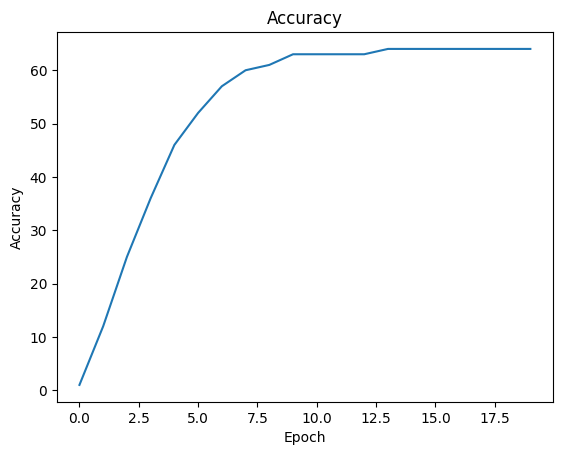

In [11]:
# Plot the testing accuracy curve across the epochs
# Remember to store all the accuracy numbers in a Python list during the training.
import matplotlib.pyplot as plt

plt.figure()
plt.plot(acc_list)
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
